In [1]:
import torch

In [26]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import root_mean_squared_error

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
device

device(type='cpu')

In [5]:
stocks = 'AMD'

In [6]:
df = yf.download(stocks, start = '2016-01-01')
df

/tmp/ipython-input-2633465777.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(stocks, start = '2016-01-01')
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,AMD,AMD,AMD,AMD,AMD
Date,,,,,
2016-01-04,2.770000,2.820000,2.630000,2.770000,32516800
2016-01-05,2.750000,2.800000,2.640000,2.770000,12972300
2016-01-06,2.510000,2.710000,2.470000,2.660000,23759400
2016-01-07,2.280000,2.480000,2.260000,2.430000,22203500
2016-01-08,2.140000,2.420000,2.100000,2.360000,31822400
...,...,...,...,...,...
2025-09-02,162.320007,162.389999,156.619995,158.419998,38656100
2025-09-03,162.130005,164.750000,160.580002,161.809998,30752800


<Axes: xlabel='Date'>

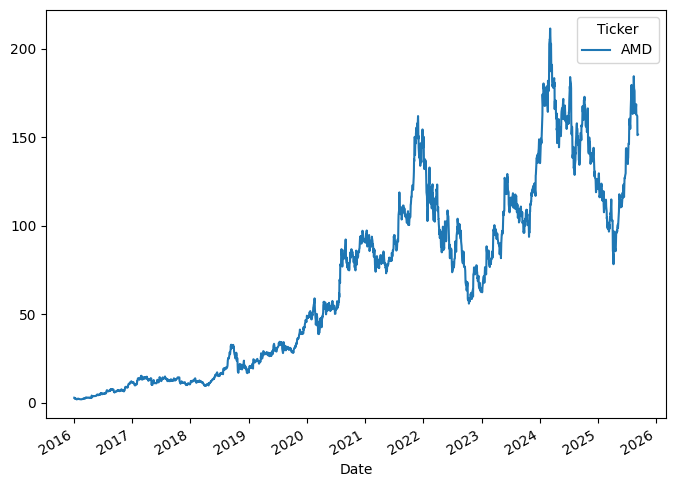

In [7]:
df.Close.plot(figsize = (8, 6))

In [8]:
scaler = StandardScaler()
df.Close = scaler.fit_transform(df.Close)
df.Close

Ticker,AMD
Date,
2016-01-04,-1.262458
2016-01-05,-1.262840
2016-01-06,-1.267416
2016-01-07,-1.271801
2016-01-08,-1.274471
...,...
2025-09-02,1.779782
2025-09-03,1.776159
2025-09-04,1.769676


In [9]:
seq_length = 30
data = []
for i in range(len(df) - seq_length):
    data.append(df.Close[i:i + seq_length])
data = np.array(data)
train_size = int(0.8 * len(data))
X_train = torch.from_numpy(data[:train_size, :-1, :]).float().to(device)

In [10]:
train_size

1923

In [11]:
X_train

tensor([[[-1.2625],
         [-1.2628],
         [-1.2674],
         ...,
         [-1.2802],
         [-1.2798],
         [-1.2804]],

        [[-1.2628],
         [-1.2674],
         [-1.2718],
         ...,
         [-1.2798],
         [-1.2804],
         [-1.2804]],

        [[-1.2674],
         [-1.2718],
         [-1.2745],
         ...,
         [-1.2804],
         [-1.2804],
         [-1.2790]],

        ...,

        [[ 0.7482],
         [ 0.6994],
         [ 0.7713],
         ...,
         [ 0.5547],
         [ 0.6441],
         [ 0.6453]],

        [[ 0.6994],
         [ 0.7713],
         [ 0.6258],
         ...,
         [ 0.6441],
         [ 0.6453],
         [ 0.6538]],

        [[ 0.7713],
         [ 0.6258],
         [ 0.6344],
         ...,
         [ 0.6453],
         [ 0.6538],
         [ 0.5930]]])

In [12]:
X_train = torch.from_numpy(data[:train_size, :-1, :]).type(torch.Tensor).to(device)
y_train = torch.from_numpy(data[:train_size, -1, :]).type(torch.Tensor).to(device)
X_test = torch.from_numpy(data[train_size:, :-1, :]).type(torch.Tensor).to(device)
y_test = torch.from_numpy(data[train_size:, -1, :]).type(torch.Tensor).to(device)

In [18]:
class PredictionModel(nn.Module):
  def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
    super(PredictionModel, self).__init__()
    self.hidden_dim = hidden_dim
    self.num_layers = num_layers
    self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first = True)
    self.fc = nn.Linear(hidden_dim, output_dim)

  def forward(self, x):
    h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim, device = device)
    c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim, device = device)
    out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
    out = self.fc(out[:, -1, :])

    return out

In [19]:
model = PredictionModel(input_dim = 1, hidden_dim = 32, num_layers = 2,
                        output_dim = 1).to(device)

In [20]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr = 0.01)

In [21]:
num_epochs = 200

for i in range(num_epochs):
  y_train_pred = model(X_train)
  loss = criterion(y_train_pred, y_train)

  if i % 25 == 0:
    print(i, loss.item())

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

0 0.6451531648635864
25 0.012950756587088108
50 0.004032546188682318
75 0.0029563880525529385
100 0.002691283356398344
125 0.0025289563927799463
150 0.002415834693238139
175 0.002322975778952241


In [24]:
model.eval()
y_test_pred = model(X_test)
y_train_pred = scaler.inverse_transform(y_train_pred.detach().cpu().numpy())
y_test_pred = scaler.inverse_transform(y_test_pred.detach().cpu().numpy())
y_train = scaler.inverse_transform(y_train.detach().cpu().numpy())
y_test = scaler.inverse_transform(y_test.detach().cpu().numpy())

In [27]:
train_rmse = root_mean_squared_error(y_train[:, 0], y_train_pred[:, 0])
test_rmse = root_mean_squared_error(y_test[:, 0], y_test_pred[:, 0])
print(train_rmse, test_rmse)

2.4858672618865967 5.4201436042785645


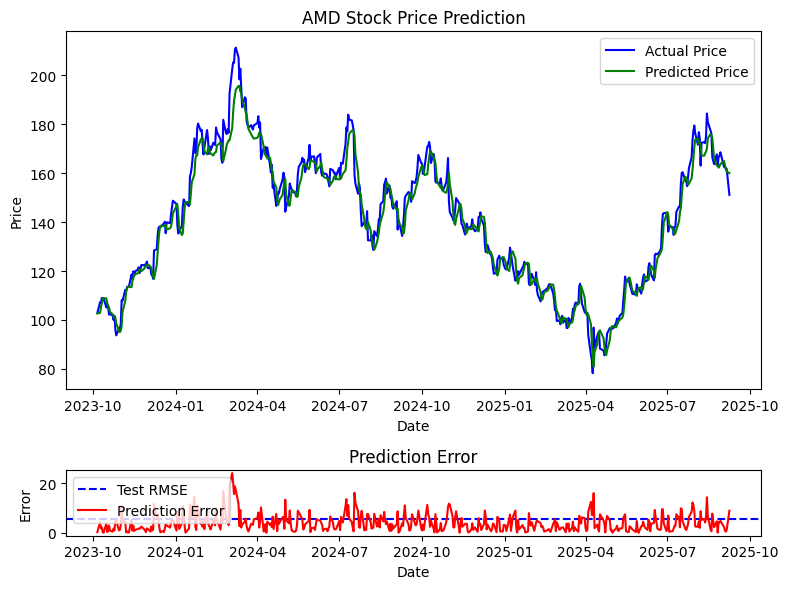

In [33]:
fig = plt.figure(figsize=(8, 6))
gs = fig.add_gridspec(4, 1)
axl = fig.add_subplot(gs[:3, 0])

# Plot actual vs predicted
axl.plot(df.iloc[-len(y_test):].index, y_test, color = 'blue', label = 'Actual Price')
axl.plot(df.iloc[-len(y_test):].index, y_test_pred, color = 'green', label = 'Predicted Price')

# Formatting
axl.legend()
plt.title(f"{stocks} Stock Price Prediction")
plt.xlabel("Date")
plt.ylabel("Price")

ax2 = fig.add_subplot(gs[3, 0])
ax2.axhline(test_rmse, color = 'blue', linestyle = '--', label = 'Test RMSE')
ax2.plot(df.iloc[-len(y_test):].index, abs(y_test - y_test_pred), color = 'red', label = 'Prediction Error')
ax2.legend()
plt.title("Prediction Error")
plt.xlabel("Date")
plt.ylabel("Error")
plt.tight_layout()
plt.show()